In [ ]:
#
import numpy as np
from pykalman import KalmanFilter
import statsmodels.stats.diagnostic as sm3
import matplotlib.pyplot as plt
#import kca
#from selectFFT import selectFFT
import statsmodels.nonparametric.smoothers_lowess as sml
import statsmodels.api as sm


mainPath = '../../'

#A1
def fitKCA(t, z, q, fwd=0):
    '''
    # Kinetic Component Analysis
    So the researcher should try alternative values of q until she settles for one that delivers
    an output consistent with her knowledge of the system. In general, lower values of q
    should be preferred, in order to mitigate overfitting.(p. 7)

    Function fitKCA has three arguments: t, z, and q. Numpy array t conveys the index of
    observations. Numpy array z passes the observations. Scalar q provides a seed value for
    initializing the EM estimation of the states covariance. Positive integer fwd determines the
    number of steps forward to be forecasted. This is an optional argument, with default value 0. (p. 14)

    Inputs:
    t: Iterable with time indices
    z: Iterable with measurements
    q: Scalar that multiplies the seed states covariance
    fwd: number of steps to forecast (optional, default=0)
    
    Output:
    x[0]: smoothed state means of position velocity and acceleration
    x[1]: smoothed state covar of position velocity and acceleration
    Dependencies: numpy, pykalman
    '''
    #1) Set up matrices A,H and a seed for Q
    h = (t[-1]-t[0])/t.shape[0]
    
    A = np.array([[1,h,.5*h**2],
                [0,1,h],
                [0,0,1]])
    
    Q = q * np.eye(A.shape[0])
    
    #2) Apply the filter
    kf = KalmanFilter(transition_matrices=A, transition_covariance=Q)
    
    #3) EM estimates
    kf = kf.em(z)
    
    #4) Smooth
    x_mean, x_covar = kf.smooth(z)

    #5) Forecast
    for fwd_ in range(fwd):
        x_mean_, x_covar_ = kf.filter_update(filtered_state_mean=x_mean[-1], \
        filtered_state_covariance = x_covar[-1])
        
        x_mean = np.append(x_mean, x_mean_.reshape(1,-1), axis=0)
        
        x_covar_ = np.expand_dims(x_covar_, axis=0)
        
        x_covar = np.append(x_covar, x_covar_, axis=0)
    
    #6) Std series
    x_std=(x_covar[:,0,0]**.5).reshape(-1,1)
    for i in range(1,x_covar.shape[1]):
        x_std_ = x_covar[:,i,i]**.5
        x_std = np.append(x_std, x_std_.reshape(-1,1), axis=1)
        
    return x_mean, x_std, x_covar


#A2
def selectFFT(series, minAlpha=None):
    """
    # FFT signal extraction with frequency selection
    # Implements a forward algorithm for selecting FFT frequencies
    """
    #1) Initialize variables
    series_ = series
    fftRes = np.fft.fft(series_, axis=0)
    fftRes = {i:j[0] for i,j in zip(range(fftRes.shape[0]),fftRes)}
    fftOpt = np.zeros(series_.shape, dtype=complex)
    lags, crit = int(12*(series_.shape[0]/100.)**.25), None
    
    #2) Search forward
    while True:
        key, critOld = None, crit
        
        for key_ in fftRes.keys():
            fftOpt[key_,0] = fftRes[key_]
            series__ = np.fft.ifft(fftOpt,axis=0)
            series__ = np.real(series__)
            crit_ = sm3.acorr_ljungbox(series_-series__,lags=lags) # test for the max # lags
            crit_ = crit_[0][-1],crit_[1][-1]
            
            if crit == None or crit_[0]<crit[0]:
                crit, key = crit_, key_
            fftOpt[key_,0]=0
            
        if key!=None:
            fftOpt[key,0] = fftRes[key]
            del fftRes[key]
        else:
            break
        
        if minAlpha!=None:
            if crit[1] > minAlpha:
                break
            if critOld != None and crit[0]/critOld[0] > 1-minAlpha:
                break
            
    series_ = np.fft.ifft(fftOpt,axis=0)
    series_ = np.real(series_)
    
    out={'series':series_,'fft':fftOpt,'res':fftRes,'crit':crit}
    
    return out


#A3
def getPeriodic(periods,nobs,scale,seed=0):
    t = np.linspace(0,np.pi*periods/2.,nobs)
    rnd = np.random.RandomState(seed)
    signal = np.sin(t)
    z = signal + scale*rnd.randn(nobs)

    return t, signal, z


def vsFFT():
    """
    # Kinetic Component Analysis of a periodic function
    """
    #1) Set parameters
    nobs, periods=300, 10
    
    #2) Get Periodic noisy measurements
    t, signal, z = getPeriodic(periods, nobs, scale=.5)
    
    #3) Fit KCA
    x_point,x_bands = kca.fitKCA(t, z, q=.001)[:2]
    
    #4) Plot KCA's point estimates
    color=['b','g','r']
    plt.plot(t,z,marker='x',linestyle='',label='measurements')
    plt.plot(t,x_point[:,0],marker='o',linestyle='-',label='position', \
    color=color[0])
    plt.plot(t,x_point[:,1],marker='o',linestyle='-',label='velocity', \
    color=color[1])
    plt.plot(t,x_point[:,2],marker='o',linestyle='-',label='acceleration', \
    color=color[2])
    
    plt.legend(loc='lower left',prop={'size':8})
    plt.savefig(mainPath+'Data/test/Figure1.png')
    
    #5) Plot KCA's confidence intervals (2 std)
    for i in range(x_bands.shape[1]):
        plt.plot(t,x_point[:,i]-2*x_bands[:,i],linestyle='-',color=color[i])
        plt.plot(t,x_point[:,i]+2*x_bands[:,i],linestyle='-',color=color[i])
        
    plt.legend(loc='lower left',prop={'size':8})
    plt.savefig(mainPath+'Data/test/Figure2.png')
    plt.clf(); plt.close() # reset pylab
    
    #6) Plot comparison with FFT
    fft = selectFFT(z.reshape(-1,1),minAlpha=.05)
    plt.plot(t,signal,marker='x',linestyle='',label='Signal')
    plt.plot(t,x_point[:,0],marker='o',linestyle='-',label='KCA position')
    plt.plot(t,fft['series'],marker='o',linestyle='-',label='FFT position')
    plt.legend(loc='lower left',prop={'size':8})
    plt.savefig(mainPath+'Data/test/Figure3.png')
    
    return


#A4
def vsLOWESS():
    """
    # Kinetic Component Analysis of a periodic function
    """
    #1) Set parameters
    nobs, periods, frac = 300, 10, [.5,.25,.1]
    
    #2) Get Periodic noisy measurements
    t, signal, z = getPeriodic(periods,nobs,scale=.5)
    
    #3) Fit KCA
    x_point, x_bands = fitKCA(t,z,q=.001)[:2]
    
    #4) Plot comparison with LOWESS
    plt.plot(t,z,marker='o',linestyle='',label='measurements')
    plt.plot(t,signal,marker='x',linestyle='',label='Signal')
    plt.plot(t,x_point[:,0],marker='o',linestyle='-',label='KCA position')
    
    for frac_ in frac:
        lowess = sml.lowess(z.flatten(), range(z.shape[0]),
                            frac=frac_)[:,1].reshape(-1,1)
        
    plt.plot(t,lowess,marker='o',linestyle='-',label='LOWESS('+str(frac_)+')')
    plt.legend(loc='lower left',prop={'size':8})
    plt.savefig(mainPath+'Data/test/Figure4.png')
    
    return

    

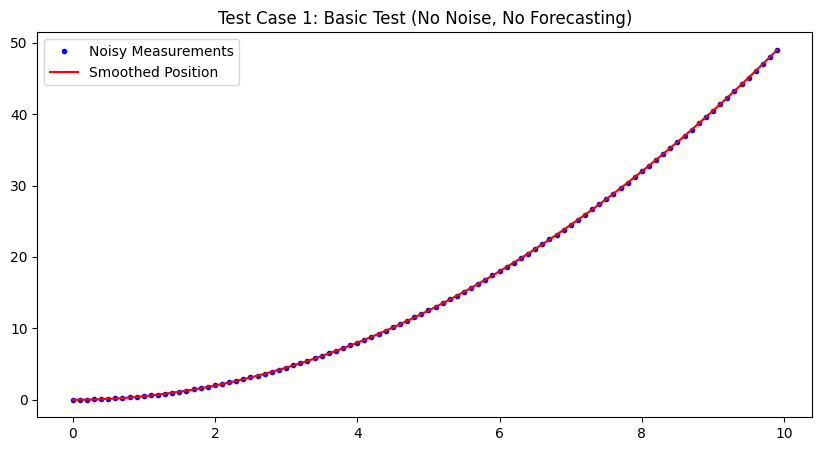

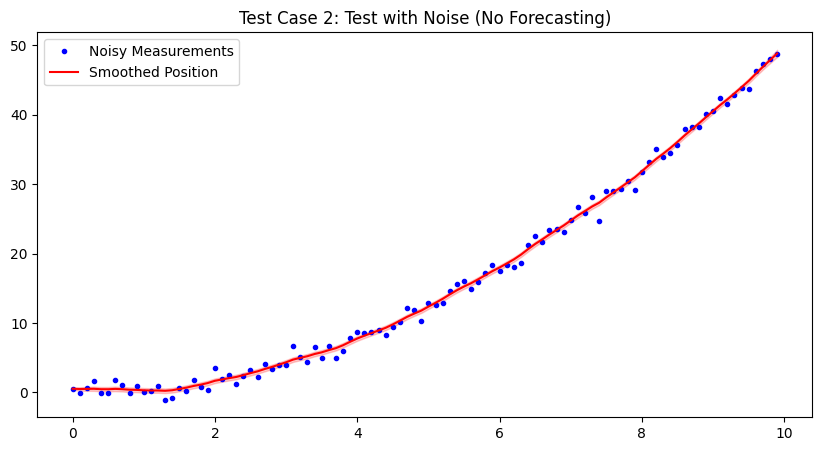

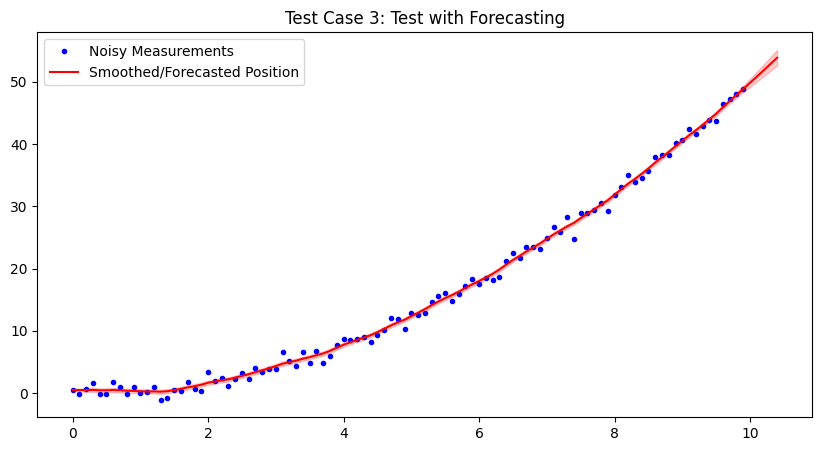

All test cases passed!


In [2]:
# Test code
def test_fitKCA():
    """
    Tests the fitKCA function with synthetic data and various parameters.
    """

    # Test Case 1: Basic test with no noise and no forecasting
    t1 = np.arange(0, 10, 0.1)
    z1 = 0.5 * t1**2  # True trajectory (parabolic)
    q1 = 0.01 
    x_mean1, x_std1, x_covar1 = fitKCA(t1, z1, q1)

    # Assertions for Test Case 1
    assert x_mean1.shape[0] == t1.shape[0], "Output size mismatch in Test Case 1"
    assert x_mean1.shape[1] == 3, "Output should have 3 state variables (position, velocity, acceleration)"

    # Visualization for Test Case 1
    plt.figure(figsize=(10, 5))
    plt.plot(t1, z1, 'b.', label='Noisy Measurements')
    plt.plot(t1, x_mean1[:, 0], 'r-', label='Smoothed Position')
    plt.fill_between(t1, x_mean1[:, 0] - x_std1[:, 0], x_mean1[:, 0] + x_std1[:, 0], color='r', alpha=0.2)
    plt.title("Test Case 1: Basic Test (No Noise, No Forecasting)")
    plt.legend()
    plt.show() #show each plot separately

    # Test Case 2: Test with added noise and no forecasting
    np.random.seed(42)
    noise2 = np.random.normal(0, 1, t1.shape)
    z2 = z1 + noise2
    q2 = 0.1
    x_mean2, x_std2, x_covar2 = fitKCA(t1, z2, q2)

    # Assertions for Test Case 2
    assert x_mean2.shape[0] == t1.shape[0], "Output size mismatch in Test Case 2"

    # Visualization for Test Case 2
    plt.figure(figsize=(10, 5))
    plt.plot(t1, z2, 'b.', label='Noisy Measurements')
    plt.plot(t1, x_mean2[:, 0], 'r-', label='Smoothed Position')
    plt.fill_between(t1, x_mean2[:, 0] - x_std2[:, 0], x_mean2[:, 0] + x_std2[:, 0], color='r', alpha=0.2)
    plt.title("Test Case 2: Test with Noise (No Forecasting)")
    plt.legend()
    plt.show() #show each plot separately

    # Test Case 3: Test with forecasting
    fwd3 = 5
    x_mean3, x_std3, x_covar3 = fitKCA(t1, z2, q2, fwd=fwd3)
    t3 = np.arange(0, 10 + fwd3 * 0.1, 0.1)

    # Assertions for Test Case 3
    assert x_mean3.shape[0] == t1.shape[0] + fwd3, "Output size mismatch in Test Case 3 (Forecasting)"

    # Visualization for Test Case 3
    plt.figure(figsize=(10, 5))
    plt.plot(t1, z2, 'b.', label='Noisy Measurements')
    plt.plot(t3, x_mean3[:, 0], 'r-', label='Smoothed/Forecasted Position')
    plt.fill_between(t3, x_mean3[:, 0] - x_std3[:, 0], x_mean3[:, 0] + x_std3[:, 0], color='r', alpha=0.2)
    plt.title("Test Case 3: Test with Forecasting")
    plt.legend()
    plt.show() #show each plot separately

    print("All test cases passed!")
    
    
test_fitKCA()

In [6]:
def test_selectFFT():
    # ... (Other test cases remain the same)

    # Test Case 1: Single dominant frequency
    t1 = np.arange(0, 10, 0.1)
    f1 = 2  # Dominant frequency
    series1 = np.sin(2 * np.pi * f1 * t1).reshape(-1, 1)
    result1 = selectFFT(series1)

    # Assertions for Test Case 1
    assert result1['crit'] is not None, "Test Case 1: Criterion value should not be None"
    # Check if the dominant frequency component is present in the selected FFT
    dominant_frequency_present = False
    fft_frequencies = np.fft.fftfreq(len(t1), d=t1[1]-t1[0])  # Get frequencies with correct sample spacing
    for i in result1['fft'].nonzero()[0]:
        if np.isclose(np.abs(fft_frequencies[i]), f1, atol=0.1):  # Use absolute frequency for comparison
            dominant_frequency_present = True
            break
    assert dominant_frequency_present, f"Test Case 1: Dominant frequency {f1} Hz not found in selected FFT"
    
    # Test Case 2: Multiple frequencies with minAlpha
    f2_1 = 1
    f2_2 = 5
    series2 = (np.sin(2 * np.pi * f2_1 * t1) + 0.5 * np.sin(2 * np.pi * f2_2 * t1)).reshape(-1, 1)
    result2 = selectFFT(series2, minAlpha=0.05)

    # Assertions for Test Case 2
    assert result2['crit'][1] <= 0.05, f"Test Case 2: Criterion p-value {result2['crit'][1]} should be below minAlpha (0.05)"
    # Check if a frequency component near to f2_1 is present
    freq1_present = False
    for i in result2['fft'].nonzero()[0]:
      if np.isclose(np.abs(fft_frequencies[i]), f2_1, atol=0.1):
          freq1_present = True
          break
    assert freq1_present, f"Test Case 2: Frequency {f2_1} Hz not found"
    # Check if a frequency component near to f2_2 is present
    freq2_present = False
    for i in result2['fft'].nonzero()[0]:
      if np.isclose(np.abs(fft_frequencies[i]), f2_2, atol=0.1):
          freq2_present = True
          break
    assert freq2_present, f"Test Case 2: Frequency {f2_2} Hz not found"
    
    # Visualization for Test Case 1
    plt.figure(figsize=(12, 4))
    plt.plot(t1, series1, label='Original Signal')
    plt.plot(t1, result1['series'], label='Filtered Signal')
    plt.title('Test Case 1: Single Dominant Frequency')
    plt.legend()
    plt.show()

    # Visualization for Test Case 2
    plt.figure(figsize=(12, 4))
    plt.plot(t1, series2, label='Original Signal')
    plt.plot(t1, result2['series'], label='Filtered Signal')
    plt.title('Test Case 2: Multiple Frequencies with minAlpha')
    plt.legend()
    plt.show()

    # Test Case 3: Random noise
    series3 = np.random.randn(100, 1)
    result3 = selectFFT(series3)
    
    # Assertions for Test Case 3
    assert result3['crit'] is not None, "Test Case 3: Criterion value should not be None"
    # With random noise, we expect the filtered signal to be close to zero
    assert np.allclose(result3['series'], 0, atol=1e-1), "Test Case 3: Filtered signal should be close to zero for random noise"

    # Visualization for Test Case 3
    plt.figure(figsize=(12, 4))
    plt.plot(np.arange(0,len(series3)), series3, label='Original Signal')
    plt.plot(np.arange(0,len(series3)), result3['series'], label='Filtered Signal')
    plt.title('Test Case 3: Random Noise')
    plt.legend()
    plt.show()

    print("All test cases passed!")

# Run the tests
test_selectFFT()

AssertionError: Test Case 1: Dominant frequency 2 Hz not found in selected FFT